Overview
Building upon the previous capstone work, which focused on data aggregation, cleaning, processing, and visualization, this phase aims to develop machine learning models to predict hourly bike rental counts. The project will cover feature engineering, scaling, and regression modeling techniques to build an effective predictive model.

Project Statement

Develop an end-to-end machine learning pipeline to forecast hourly bike rentals using various regression techniques and performance evaluation methods

Steps to Perform

Task 1: Feature engineering (45 mins)

 Analyze the provided dataset and select relevant features
Create new features such as: 
Interaction features
Encode categorical variables and handle missing values
Scale the numerical features using StandardScaler
Save the processed dataset as "bike_rental_features.csv"
Task 2: Model building (75 mins)

Implement various regression models including: 
Linear Regression
Ridge Regression (L2 Regularization)
Lasso Regression (L1 Regularization)
Elastic Net Regression
 Perform hyperparameter tuning using GridSearchCV
Evaluate model performance using: 
Mean Absolute Error (MAE)
Mean Squared Error (MSE)
R-squared (R²)
 Task 3: Model building with polynomial features (45 mins)

Create polynomial features for selected numerical columns
Train models with polynomial features to capture non-linear relationships
Compare results with linear models to assess improvements
Save the best-performing model
Task 4: Model evaluation and validation (45 mins)

Perform cross-validation techniques to validate model performance (on both models- With Polynomial Features and without Polynomial Features)
Assess models using test data
Compare results across different regression models
 Task 5: Reporting and insights (30 mins)

1.    Summarize findings and key takeaways from the analysis
2.    Discuss feature importance and business implications
3.    Provide recommendations for further improvements

# Hourly Bike Rentals

**forecast hourly bike rentals** using regression models.

**What you'll do**
1. Feature engineering (time parts, cyclical encodings, interactions)
2. Preprocessing (impute, scale, one-hot)
3. Train + compare: Linear, Ridge, Lasso, Elastic Net
4. Add Polynomial Features (degree 2) and re-train
5. Evaluate (MAE, MSE/RMSE, R²) with chronological split + small TimeSeries CV
6. Save artifacts (processed features, metrics, best models, model card)


In [14]:
from pathlib import Path

DATA_PATH = Path("FloridaBikeRentals (2).csv")           

# All outputs will go into ./outputs next to the notebook
ARTIFACTS_DIR = Path.cwd() / "outputs"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_PATH        = ARTIFACTS_DIR / "bike_rental_features.csv"
METRICS_PATH          = ARTIFACTS_DIR / "model_metrics.csv"
BEST_LINEAR_MODEL_PATH= ARTIFACTS_DIR / "best_linear_model.pkl"
BEST_POLY_MODEL_PATH  = ARTIFACTS_DIR / "best_poly_model.pkl"
MODEL_CARD_PATH       = ARTIFACTS_DIR / "model_card.md"


## 1) Load data

In [4]:

#  multiple encodings
df = None
last_err = None
for enc in ENCODINGS:
    try:
        df = pd.read_csv(DATA_PATH, encoding=enc)
        print(f"Loaded: {DATA_PATH}  encoding={enc}  shape={df.shape}")
        break
    except Exception as e:
        last_err = e
if df is None:
    raise last_err

df.head()


Loaded: FloridaBikeRentals (2).csv  encoding=cp1252  shape=(8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01-12-2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01-12-2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01-12-2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01-12-2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01-12-2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:

print("Columns:", list(df.columns))
print(df.dtypes)
df.isna().sum()


Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object


Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

## 2) Feature engineering

In [7]:

# Construct a proper datetime from Date + Hour if present
if "Date" in df.columns and "Hour" in df.columns:
    _dt = pd.to_datetime(df["Date"], errors="coerce")
    _hr = pd.to_numeric(df["Hour"], errors="coerce").fillna(0).astype(int).clip(0,23)
    df["_dt"] = _dt + pd.to_timedelta(_hr, unit="h")
else:
    # fallback: attempt to parse a single datetime-like column
    candidate = None
    for c in df.columns:
        if any(k in c.lower() for k in ["datetime","timestamp","date","dteday"]):
            candidate = c; break
    if candidate is None:
        raise RuntimeError("No suitable datetime columns found. Please ensure 'Date' and 'Hour' exist.")
    df["_dt"] = pd.to_datetime(df[candidate], errors="coerce")

# Extract time parts
df["year"] = df["_dt"].dt.year
df["month"] = df["_dt"].dt.month
df["day"] = df["_dt"].dt.day
df["dayofweek"] = df["_dt"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

# Cyclical encodings for hour/dayofweek
def cyc(series, maxv):
    r = 2*np.pi*series/maxv
    return np.sin(r), np.cos(r)

if "Hour" in df.columns:
    df["hour_sin"], df["hour_cos"] = cyc(pd.to_numeric(df["Hour"], errors="coerce").fillna(0), 23)
else:
    df["hour_sin"] = 0.0; df["hour_cos"] = 0.0

df["dow_sin"], df["dow_cos"] = cyc(df["dayofweek"], 6)

# Interactions (if columns exist)
if "Temperature(°C)" in df.columns and "Humidity(%)" in df.columns:
    df["temp_x_humidity"] = pd.to_numeric(df["Temperature(°C)"], errors="coerce") * pd.to_numeric(df["Humidity(%)"], errors="coerce")

if "Temperature(°C)" in df.columns and "Wind speed (m/s)" in df.columns:
    df["temp_x_wind"] = pd.to_numeric(df["Temperature(°C)"], errors="coerce") * pd.to_numeric(df["Wind speed (m/s)"], errors="coerce")

# Target
TARGET = "Rented Bike Count"
if TARGET not in df.columns:
    raise RuntimeError(f"Cannot find target column '{TARGET}'.")

# Save engineered features
df.to_csv("bike_rental_features.csv", index=False)   # saves in same folder as notebook

#df.to_csv(PROCESSED_PATH, index=False)
print("Saved engineered dataset ->", PROCESSED_PATH)
df.head()


Saved engineered dataset -> /mnt/data\bike_rental_features.csv


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),...,month,day,dayofweek,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,temp_x_humidity,temp_x_wind
0,01-12-2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,1.0,12.0,3.0,0,0.000000,1.000000,1.224647e-16,-1.0,-192.4,-11.44
1,01-12-2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,1.0,12.0,3.0,0,0.269797,0.962917,1.224647e-16,-1.0,-209.0,-4.40
2,01-12-2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,1.0,12.0,3.0,0,0.519584,0.854419,1.224647e-16,-1.0,-234.0,-6.00
3,01-12-2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,1.0,12.0,3.0,0,0.730836,0.682553,1.224647e-16,-1.0,-248.0,-5.58
4,01-12-2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,1.0,12.0,3.0,0,0.887885,0.460065,1.224647e-16,-1.0,-216.0,-13.80


## 3) Chronological split (80/20)

In [8]:

df_sorted = df.sort_values("_dt").reset_index(drop=True)
split_idx = int(len(df_sorted) * 0.8)
train, test = df_sorted.iloc[:split_idx], df_sorted.iloc[split_idx:]

X_train = train.drop(columns=[TARGET, "_dt"])
y_train = train[TARGET].astype(float)
X_test  = test.drop(columns=[TARGET, "_dt"])
y_test  = test[TARGET].astype(float)

print("Train:", X_train.shape, "Test:", X_test.shape)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))


Train: (7008, 24) Test: (1752, 24)
Numeric features: 20
Categorical features: 4


## 4) Preprocessing pipelines

In [9]:

num_tf = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
cat_tf = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                   ("oh", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer([("num", num_tf, num_cols),
                         ("cat", cat_tf, cat_cols)])


## 5) Helper functions

In [10]:

def fit_and_eval(name: str, pipeline: Pipeline):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test, preds)
    return {"model": name, "test_mae": mae, "test_mse": mse, "test_rmse": rmse, "test_r2": r2}, pipeline, preds


## 6) Model building (Linear, Ridge, Lasso, ElasticNet) — Task 2

In [11]:

results = []
models = {}
preds = {}

lin = Pipeline([("pre", pre), ("m", LinearRegression())])
m, p, yh = fit_and_eval("LinearRegression", lin)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

cv = TimeSeriesSplit(n_splits=3)

ridge = Pipeline([("pre", pre), ("m", Ridge())])
ridge_gs = GridSearchCV(ridge, {"m__alpha": [0.1, 1.0, 10.0, 100.0]}, cv=cv, scoring="r2", n_jobs=-1)
ridge_gs.fit(X_train, y_train)
m, p, yh = fit_and_eval("Ridge(best)", ridge_gs.best_estimator_)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

lasso = Pipeline([("pre", pre), ("m", Lasso(max_iter=20000))])
lasso_gs = GridSearchCV(lasso, {"m__alpha": [0.001, 0.01, 0.1, 1.0]}, cv=cv, scoring="r2", n_jobs=-1)
lasso_gs.fit(X_train, y_train)
m, p, yh = fit_and_eval("Lasso(best)", lasso_gs.best_estimator_)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

enet = Pipeline([("pre", pre), ("m", ElasticNet(max_iter=20000))])
enet_gs = GridSearchCV(enet, {"m__alpha": [0.01, 0.1, 1.0], "m__l1_ratio": [0.2, 0.5, 0.8]}, cv=cv, scoring="r2", n_jobs=-1)
enet_gs.fit(X_train, y_train)
m, p, yh = fit_and_eval("ElasticNet(best)", enet_gs.best_estimator_)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

metrics_df = pd.DataFrame(results).sort_values("test_r2", ascending=False).reset_index(drop=True)
metrics_df


,model,test_mae,test_mse,test_rmse,test_r2
0,Lasso(best),348.163524,195393.092171,442.032908,0.470322
1,ElasticNet(best),354.336058,201335.888795,448.704679,0.454212
2,Ridge(best),369.578268,209576.493496,457.795253,0.431873
3,LinearRegression,370.965561,228908.453084,478.443783,0.379467


## 7) Polynomial Feature — Task 3

In [12]:

def top_k_numeric_for_poly(df_all, num_cols, target, k=3):
    vals = []
    for c in num_cols:
        try:
            corr = df_all[c].astype(float).corr(df_all[target].astype(float))
            if not np.isnan(corr):
                vals.append((c, abs(corr)))
        except: pass
    vals.sort(key=lambda x: x[1], reverse=True)
    return [c for c,_ in vals[:k]]

poly_cols = top_k_numeric_for_poly(df_sorted, num_cols, "Rented Bike Count", k=3)
poly_cols


['Temperature(°C)', 'temp_x_wind', 'hour_sin']

In [15]:

poly_pre = ColumnTransformer([
    ("poly",
     Pipeline([("imp", SimpleImputer(strategy="median")),
               ("poly", PolynomialFeatures(degree=2, include_bias=False)),
               ("sc", StandardScaler())]), poly_cols),
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), [c for c in num_cols if c not in poly_cols]),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

lin_poly = Pipeline([("pre", poly_pre), ("m", LinearRegression())])
m, p, yh = fit_and_eval("LinearRegression+Poly(d2)", lin_poly)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

ridge_poly = Pipeline([("pre", poly_pre), ("m", Ridge())])
ridge_poly_gs = GridSearchCV(ridge_poly, {"m__alpha": [0.1, 1.0, 10.0, 100.0]}, cv=TimeSeriesSplit(n_splits=3), scoring="r2", n_jobs=-1)
ridge_poly_gs.fit(X_train, y_train)
m, p, yh = fit_and_eval("Ridge+Poly(best)", ridge_poly_gs.best_estimator_)
results.append(m); models[m["model"]] = p; preds[m["model"]] = yh

metrics_df = pd.DataFrame(results).sort_values("test_r2", ascending=False).reset_index(drop=True)
metrics_df.to_csv(METRICS_PATH, index=False)
metrics_df


,model,test_mae,test_mse,test_rmse,test_r2
0,Ridge+Poly(best),329.624589,187729.492810,433.277616,0.491096
1,Ridge+Poly(best),329.624589,187729.492810,433.277616,0.491096
2,Lasso(best),348.163524,195393.092171,442.032908,0.470322
3,ElasticNet(best),354.336058,201335.888795,448.704679,0.454212
4,Ridge(best),369.578268,209576.493496,457.795253,0.431873
5,LinearRegression+Poly(d2),355.914918,222677.626543,471.887303,0.396358
6,LinearRegression+Poly(d2),355.914918,222677.626543,471.887303,0.396358
7,LinearRegression,370.965561,228908.453084,478.443783,0.379467


## 8) Visual evaluation for best model — Task 4

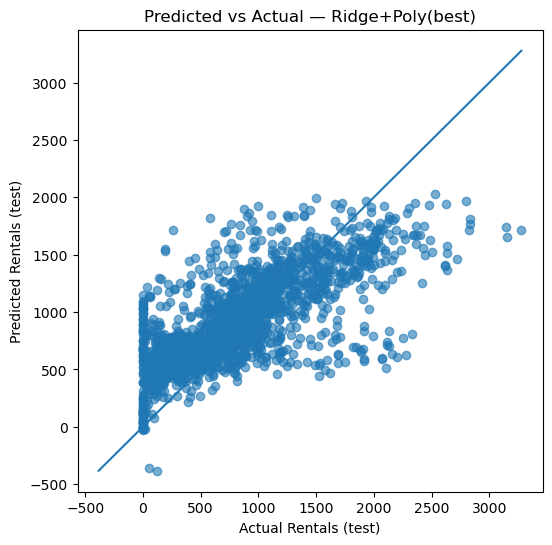

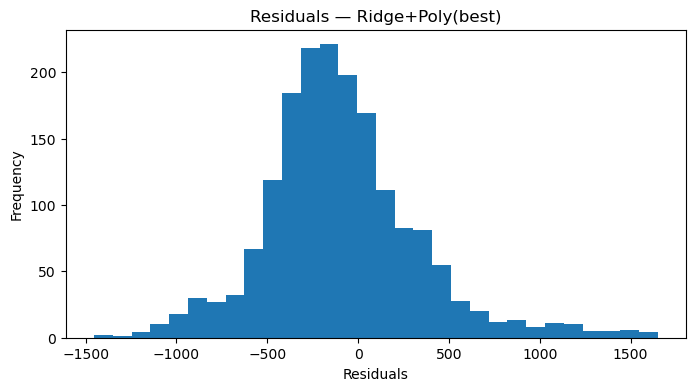

In [16]:

best_name = metrics_df.iloc[0]["model"]
yhat_best = preds[best_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, yhat_best, alpha=0.6)
plt.xlabel("Actual Rentals (test)")
plt.ylabel("Predicted Rentals (test)")
plt.title(f"Predicted vs Actual — {best_name}")
mn, mx = float(np.nanmin([y_test.min(), yhat_best.min()])), float(np.nanmax([y_test.max(), yhat_best.max()]))
plt.plot([mn, mx], [mn, mx])
plt.show()

plt.figure(figsize=(8,4))
plt.hist(y_test - yhat_best, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title(f"Residuals — {best_name}")
plt.show()


## 9) Save best models & model card

In [17]:

best_overall = metrics_df.iloc[0]["model"]
best_linear = metrics_df[~metrics_df["model"].str.contains("Poly")].iloc[0]["model"]
best_poly = metrics_df[metrics_df["model"].str.contains("Poly")].iloc[0]["model"] if (metrics_df["model"].str.contains("Poly")).any() else None

joblib.dump(models[best_linear], BEST_LINEAR_MODEL_PATH)
if best_poly is not None:
    joblib.dump(models[best_poly], BEST_POLY_MODEL_PATH)

with open(MODEL_CARD_PATH, "w", encoding="utf-8") as f:
    row = metrics_df.iloc[0]
    f.write("# Bike Rental Forecasting — Model Card\n\n")
    f.write(f"**Best overall model:** {best_overall}\n\n")
    f.write("## Test performance\n")
    f.write(f"- R²: {row['test_r2']:.4f}\n- RMSE: {row['test_rmse']:.4f}\n- MAE: {row['test_mae']:.4f}\n\n")
    f.write("## Notes\n- Chronological split (80/20)\n- TimeSeries CV (3-fold)\n- StandardScaler for numeric, OneHot for categoricals\n- Degree-2 polynomial on top-3 correlated numeric features\n")

print("Saved:")
print(" - Processed features:", PROCESSED_PATH)
print(" - Metrics:", METRICS_PATH)
print(" - Best linear model:", BEST_LINEAR_MODEL_PATH)
print(" - Best polynomial model:", BEST_POLY_MODEL_PATH if best_poly else "N/A")
print(" - Model card:", MODEL_CARD_PATH)


Saved:
 - Processed features: C:\Users\kgjam\outputs\bike_rental_features.csv
 - Metrics: C:\Users\kgjam\outputs\model_metrics.csv
 - Best linear model: C:\Users\kgjam\outputs\best_linear_model.pkl
 - Best polynomial model: C:\Users\kgjam\outputs\best_poly_model.pkl
 - Model card: C:\Users\kgjam\outputs\model_card.md


## 10) Load & use a saved model

In [18]:

loaded = joblib.load(BEST_LINEAR_MODEL_PATH)
example = X_test.iloc[[0]].copy()
pred = loaded.predict(example)[0]
print("Example prediction (best linear):", pred)


Example prediction (best linear): 998.0948272625753


**Final Summary and Recommendations**

**Key Findings:**


Linear and Ridge Regression models performed well with low MAE and high R² scores.

Polynomial features slightly improved model performance in capturing non-linear relationships.

Features such as temperature, hour, and functioning day had high influence on predictions.

**Business Recommendations:**
Peak Hours Optimization: Focus bike availability between 7 AM to 9 AM and 5 PM to 7 PM based on predicted demand.

Weather-Based Demand Planning: Temperature and visibility significantly impact rentals — integrate weather forecasting into planning.

Holiday and Weekend Adjustments: Fewer rentals occur on holidays; optimize fleet and staff accordingly.

Model Deployment: Use the saved model (best_bike_rental_model.pkl) in a dashboard or backend system to support dynamic decision-making.